In [7]:
# Plot the comparison between the waveforms and spectra of two different templates on multiple stations

In [8]:
## Import modules
from matplotlib.pyplot import subplots
from matplotlib import ticker
from obspy import read, UTCDateTime
from utils_snuffler import read_normal_markers
from utils_preproc import read_and_process_windowed_waveforms
from utils_spec import get_data_spectrum, get_filter_response
from pandas import DataFrame
from os.path import join
from numpy import amax, abs

In [9]:
## Inputs
timewin1 = "2020-01-12-17-00-00"
timewin2 = "2020-01-16-08-00-00"

name1 = "TwinA12-17-23-38"
name2 = "TwinB16-08-06-34"

rootdir = "/Volumes/OmanData/geophones_no_prefilt/data"
phase = "X"
component = "Z"

stadict = {"template1": ["A04", "A06", "A03", "A02", "A01"], "template2": ["B04", "B06", "B03", "B02", "B01"]}

freqmin = 10
freqmax = 450

begin = -0.02
end = 0.3

In [10]:
## Read the snuffer pick files
pickdf1 = read_normal_markers(join(rootdir, timewin1, f"{phase.lower()}picks_{name1}.dat"))
pickdf2 = read_normal_markers(join(rootdir, timewin2, f"{phase.lower()}picks_{name2}.dat"))

In [11]:
## Read and process the waveform
stream1 = read_and_process_windowed_waveforms(pickdf1, freqmin, freqmax, begin=begin, end=end, reference="individual")
stream2 = read_and_process_windowed_waveforms(pickdf2, freqmin, freqmax, begin=begin, end=end, reference="individual")

A04
A03
A02
A06
A05
A01
B04
B06
B02
B01
B03


Figure saved to /Volumes/OmanData/geophones_no_prefilt/data/template_compare_TwinA12-17-23-38_TwinB16-08-06-34.png


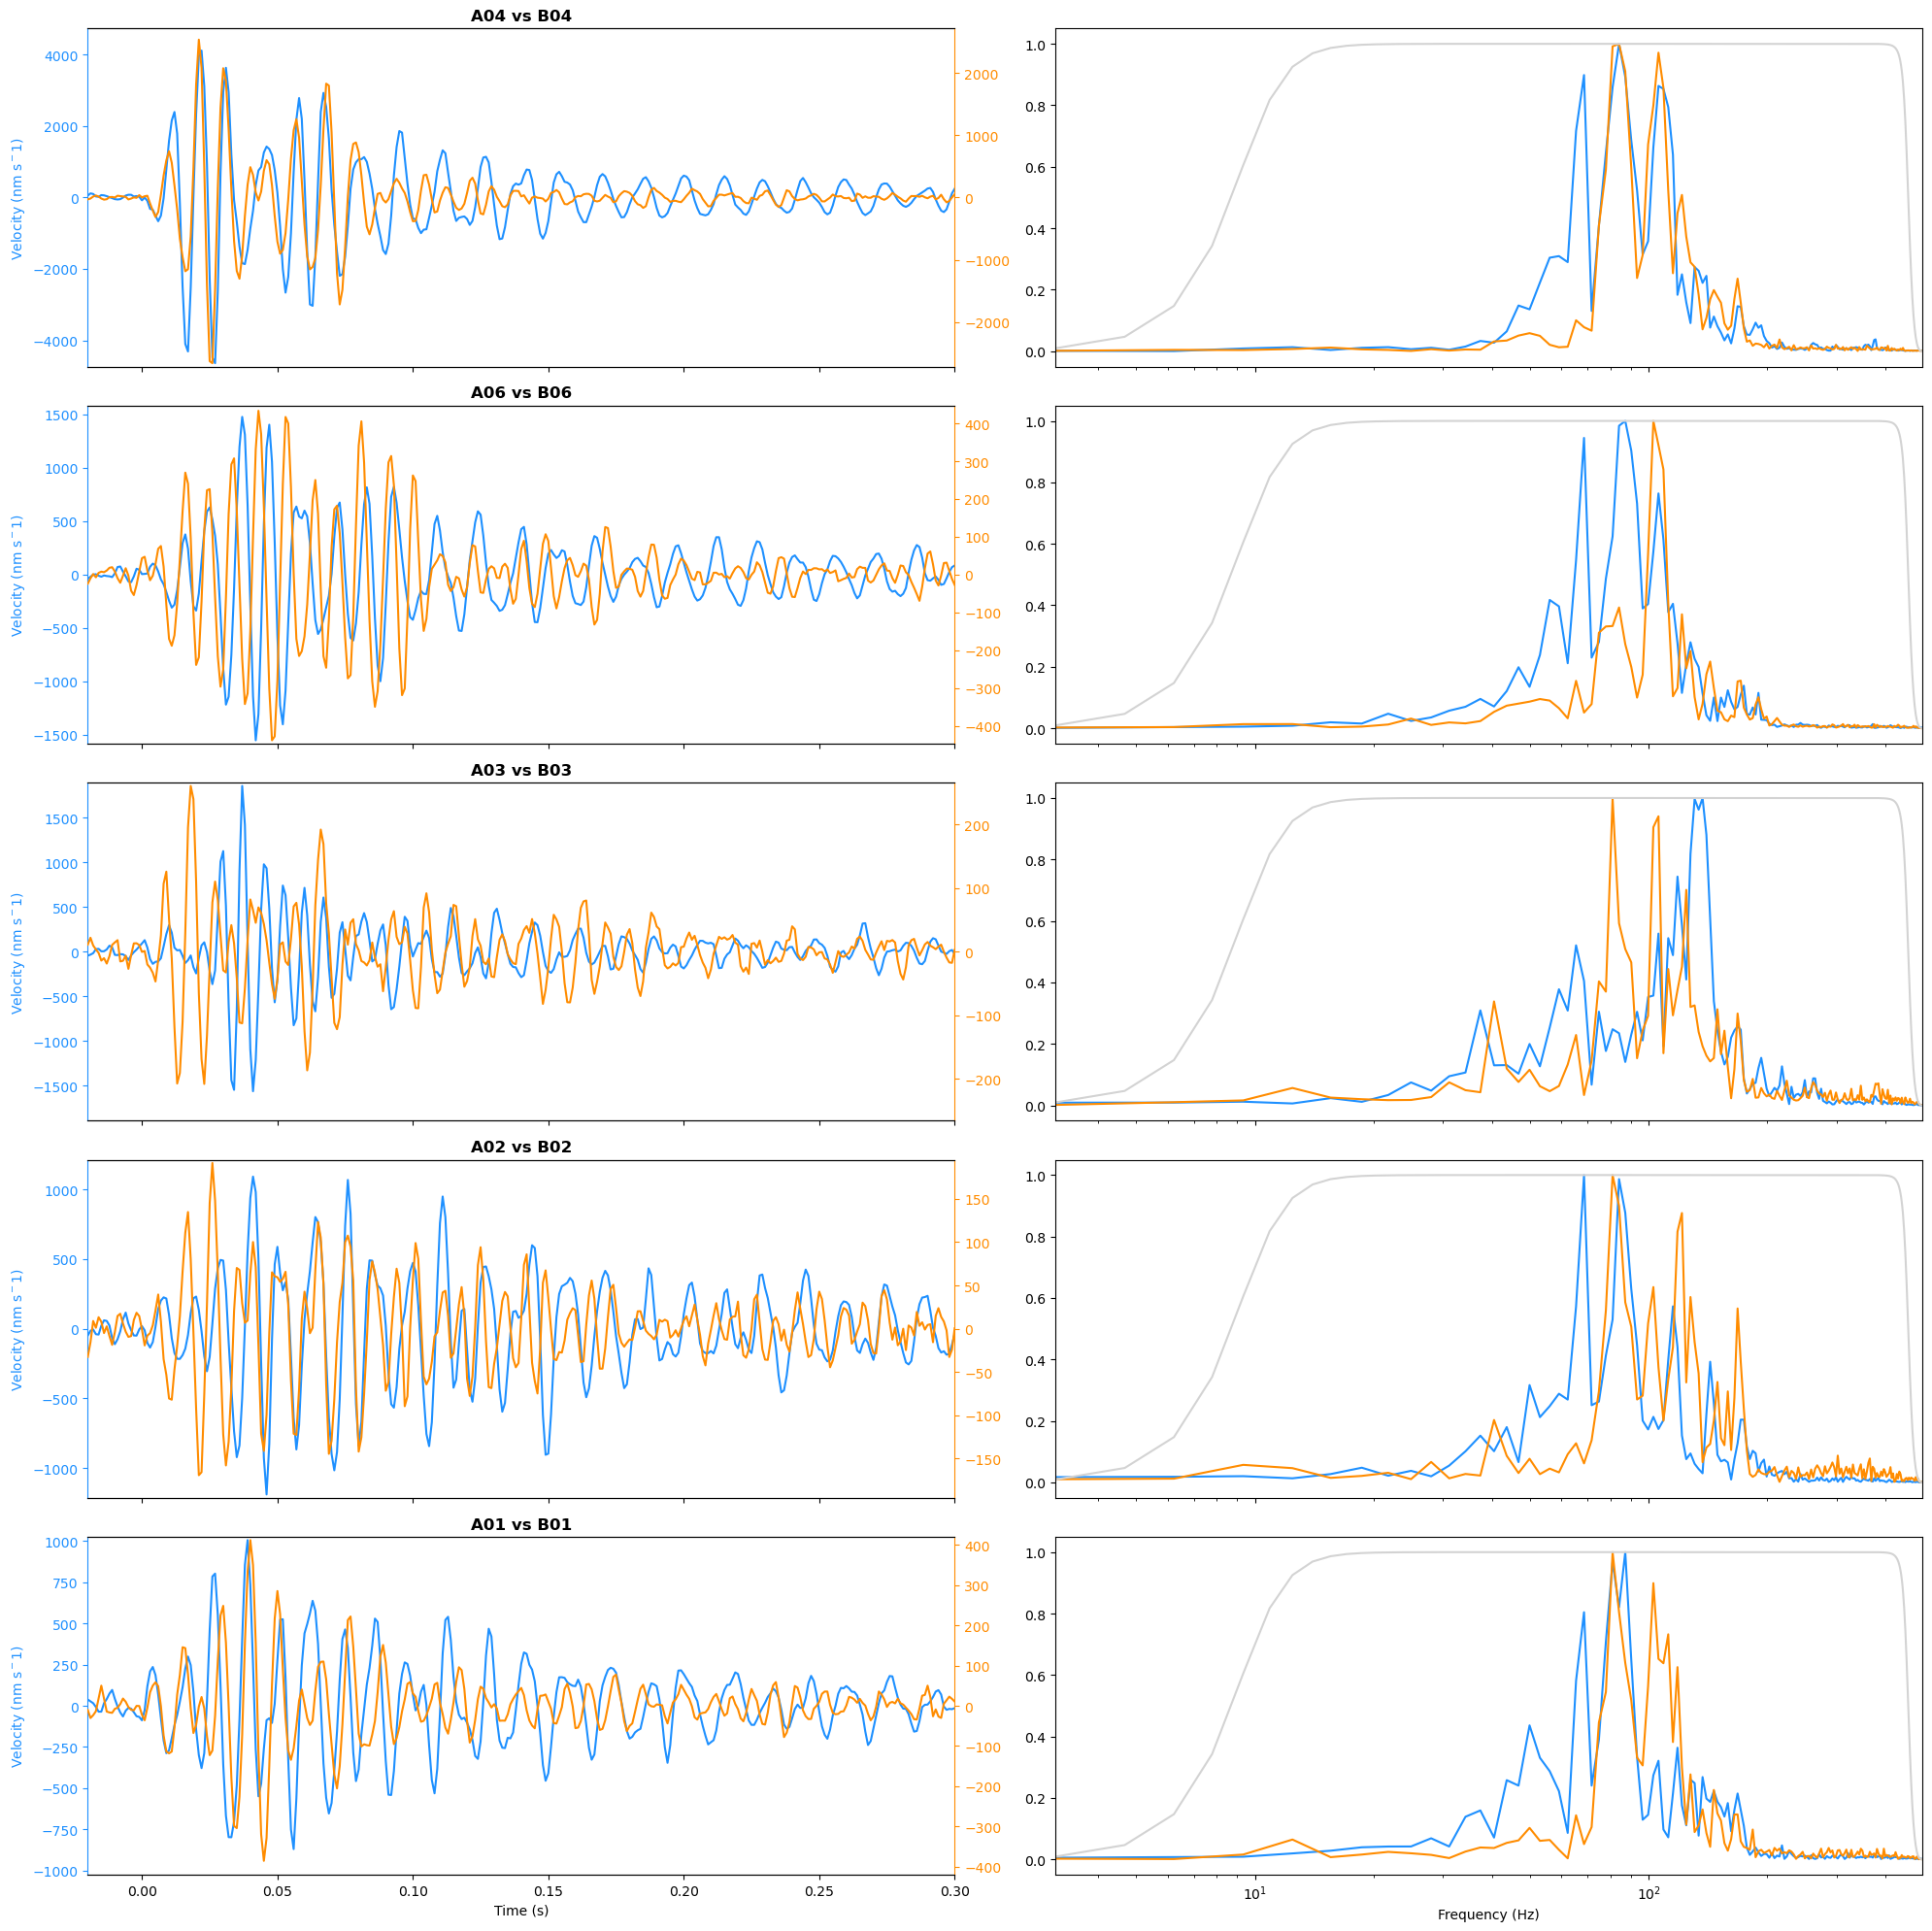

In [12]:
## Define the subplots
stadf = DataFrame(stadict)
numst = len(stadf)

fig, axes = subplots(nrows=numst, ncols=2, figsize=(20, 20))

## Plot the waveforms and spectra
for i, row in stadf.iterrows():

    ### Plot the waveforms
    station1 = row["template1"]
    station2 = row["template2"]

    trace1 = stream1.select(station=station1, component=component)[0]
    trace2 = stream2.select(station=station2, component=component)[0]

    data1 = trace1.data
    data2 = trace2.data

    timeax1 = trace1.times()+begin
    timeax2 = trace2.times()+begin

    ax_wave1 = axes[i, 0]
    ax_wave2 = ax_wave1.twinx()

    ax_wave1.plot(timeax1, data1, color="dodgerblue", label="A")
    ax_wave2.plot(timeax2, data2, color="darkorange", label="B")

    amp1 = amax(abs(data1))
    amp2 = amax(abs(data2))

    ax_wave1.set_ylim(-1.02*amp1, 1.02*amp1)
    ax_wave2.set_ylim(-1.02*amp2, 1.02*amp2)

    ax_wave1.set_xlim(begin, end)

    ax_wave1.spines['left'].set_color('dodgerblue')
    ax_wave1.spines['right'].set_color(None)
    ax_wave2.spines['right'].set_color('darkorange')
    ax_wave2.spines['left'].set_color(None)

    ax_wave1.tick_params(axis='y', colors='dodgerblue')
    ax_wave2.tick_params(axis='y', colors='darkorange')

    ax_wave1.set_ylabel("Velocity (nm s$^-1$)", color="dodgerblue")

    ax_wave1.set_title(f"{station1} vs {station2}", fontweight="bold")

    ### Plot the spectra
    samprat1 = trace1.stats.sampling_rate
    samprat2 = trace2.stats.sampling_rate

    freqax1, spec1 = get_data_spectrum(data1, samprat1)
    freqax2, spec2 = get_data_spectrum(data2, samprat2)

    ax_spec = axes[i, 1]
    ax_spec.plot(freqax1, spec1, color="dodgerblue")
    ax_spec.plot(freqax2, spec2, color="darkorange")

    ax_spec.set_xscale('log')
    ax_spec.set_xlim(freqax1[0], freqax1[-1])

    if i < numst-1:
        ax_wave1.set_xticklabels([])
        ax_wave2.set_xticklabels([])
        ax_spec.set_xticklabels([])
    else:
        ax_wave1.set_xlabel("Time (s)")
        ax_spec.set_xlabel("Frequency (Hz)")

    ### Plot the filter response
    numpts = len(data1)
    freqax, filterresp = get_filter_response(freqmin, freqmax, samprat1, numpts)
    ax_spec.plot(freqax, filterresp, color="lightgray")

## Save the figure 
fig.tight_layout()

outpath= join(rootdir, f"template_compare_{name1}_{name2}.png")
fig.savefig(outpath, dpi=300, transparent=True)
print(f"Figure saved to {outpath}")